<a href="https://colab.research.google.com/github/SurakshaRV/Chatbot-for-skin-disease-diagnosis/blob/main/skin_disease_classification_with_MobileNets_finetuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the libraries
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# The paths for the training, validation and test images
train_path = '/content/drive/My Drive/Kaggle_base_dir.zip (Unzipped Files)/base_dir/train_dir'
valid_path = '/content/drive/My Drive/Kaggle_base_dir.zip (Unzipped Files)/base_dir/test_dir/val_dir'
test_path= '/content/drive/My Drive/Kaggle_base_dir.zip (Unzipped Files)/base_dir/test_dir/testing_dir'

#number of images in the training set
num_train_samples = 6009
#number of images in the evaluation set
num_val_samples = 2003
#number of images in the test set
num_test_samples = 2004
#dimensions of the image that will be inputed into the network (224x224)
image_size = 224
# batch size initialization
train_batch_size = 20
val_batch_size = 20
test_batch_size = 20

# Declare how many steps are needed in an iteration
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
# Set up generators
train_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, #pointing to the path where the training images are stored
    target_size=(image_size, image_size), #the target size of the image output
    batch_size=train_batch_size) #size of the training batches

valid_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path, #pointing to the path where the validation images are stored
    target_size=(image_size, image_size), #the target size of the image output
    batch_size=val_batch_size)  #size of the validation batches

test_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path,
    target_size=(image_size, image_size), #the target size of the image output
    batch_size=val_batch_size,  #size of the test batches
    shuffle=False)

Found 25591 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.
Found 2004 images belonging to 7 classes.


In [ ]:
#Create a MobileNet model
mobile = keras.applications.mobilenet.MobileNet()

# Modify the model
# Choose the 6th layer from the last
x = mobile.layers[-6].output

# Add a dropout and dense layer for predictions
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# Create a new model with the new outputs
model = Model(inputs=mobile.input, outputs=predictions)

# Prevent everything except the last 23 layers from being trained
for layer in model.layers[:-23]:
  layer.trainable = False

In [ ]:
# Define Top2 and Top3 Accuracy
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

# Add weights to make the model more sensitive to specific diseases
class_weights={
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 1.0,  # mel
    5: 1.0,  # nv
    6: 1.0,  # vasc
}

In [ ]:
filepath = "skin_lesion_model.h5" #where mdel weights are to be stored

# Compile the model
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

# Declare a checkpoint to save the best version of the model
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

# Fit the model
history = model.fit_generator(train_batches,
                              steps_per_epoch=train_steps,
                              class_weight=class_weights,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=20,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/20
301/301 [==============================] - ETA: 0s - loss: 1.2692 - categorical_accuracy: 0.5776 - top_2_accuracy: 0.7643 - top_3_accuracy: 0.8796
Epoch 00001: val_top_3_accuracy improved from -inf to 0.91363, saving model to skin_lesion_model.h5
301/301 [==============================] - 745s 2s/step - loss: 1.2692 - categorical_accuracy: 0.5776 - top_2_accuracy: 0.7643 - top_3_accuracy: 0.8796 - val_loss: 1.4570 - val_categorical_accuracy: 0.6810 - val_top_2_accuracy: 0.8078 - val_top_3_accuracy: 0.9136
Epoch 2/20
301/301 [==============================] - ETA: 0s - loss: 0.8063 - categorical_accuracy: 0.7018 - top_2_accuracy: 0.8694 - top_3_accuracy: 0.9505
Epoch 00002: val_top_3_accuracy improved from 0.91363 to 0.93759, saving model to skin_lesion_model.h5
301/301 [==============================] - 608s 2s/step - loss: 0.8063 - categorical_accuracy: 0.7018 - top_2_accuracy: 0.8694 - top_3_accuracy: 0.9505 - val_loss: 1.8331 - val_categorical_accuracy: 0.6750 - val_top_2

In [ ]:
# Evaluation of the best epoch
model.load_weights('skin_lesion_model.h5')

test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc = model.evaluate_generator(test_batches, steps=val_steps)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
test_loss: 0.5832375884056091
test_cat_acc: 0.8013972043991089
test_top_2_acc: 0.9301397204399109
test_top_3_acc: 0.9725548624992371


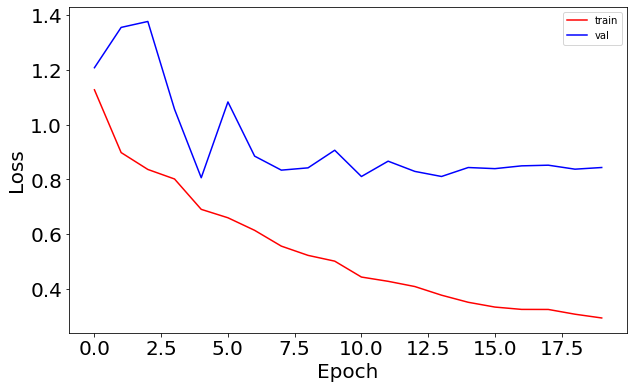

In [ ]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

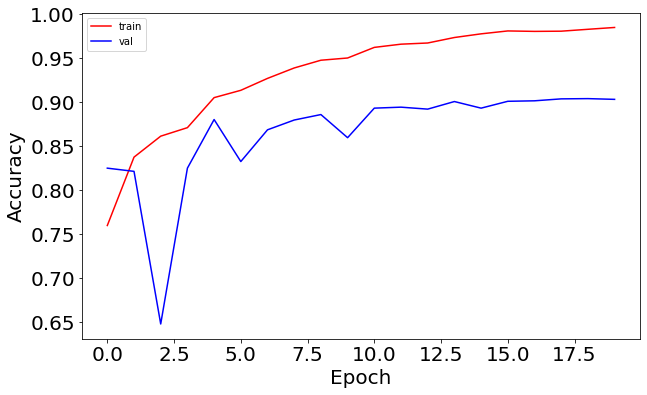

In [ ]:
# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['categorical_accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_categorical_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [ ]:
# Create a confusion matrix of the test images
test_labels = test_batches.classes

# Make predictions
predictions = model.predict_generator(test_batches, steps=val_steps, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
101/101 [==============================] - 92s 912ms/step


In [ ]:
# Declare a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[  45    3   10    0    6    1    0]
 [   8   67   11    0    6   10    1]
 [  12    4  146    0   19   39    0]
 [   0    1    0   12    4    6    0]
 [   7    0   28    1   94   92    0]
 [  13   11   44    3   47 1221    3]
 [   0    3    1    0    1    3   21]]


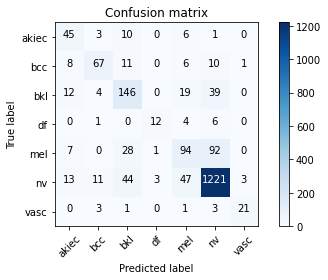

In [ ]:
#plot the matrix
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# matrix labels
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels)

In [ ]:
#learning rate regularization (only for reference)
print(history.history['lr'])

[0.01, 0.01, 0.01, 0.01, 0.005, 0.005, 0.005, 0.0025, 0.0025, 0.0025, 0.00125, 0.00125, 0.00125, 0.000625, 0.000625, 0.0003125, 0.0003125, 0.00015625, 0.00015625, 7.8125e-05]
